In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
#  read data 
file_path = 'Total E-waste generated.xlsx'
def date_parser(year):
    return pd.to_datetime(str(year), format='%Y')
try:
    df = pd.read_excel(file_path,parse_dates=['Date'], index_col='Date')
    print(df.head())
except Exception as e:
    print("Error:", e)

              Total
Date               
2010-01-01  1299581
2011-01-01  1340242
2012-01-01  1377532
2013-01-01  1413527
2014-01-01  1448408


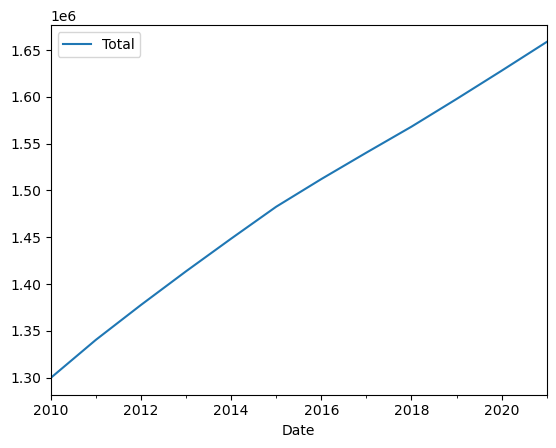

In [26]:
# Plot data
df.plot()
plt.show()

In [27]:
import statsmodels.api as sm

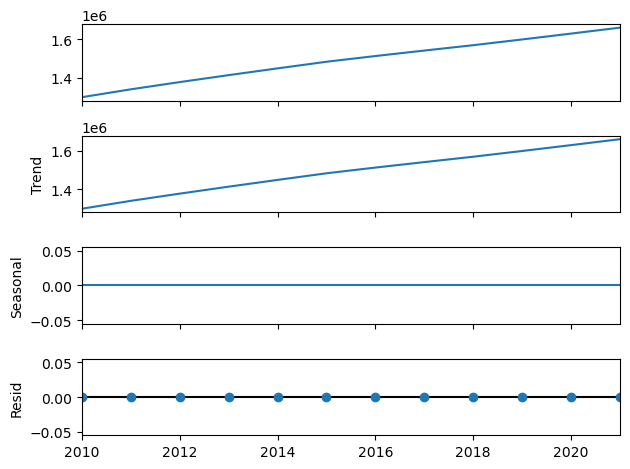

In [28]:
# decompose data to check for seasonality and trend
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
# check the pvalue of dateset to determine stationarity
adfest = adfuller(df)

print('p value of adfuller test is', adfest[1])

p value of adfuller test is 0.9773753730033956


In [33]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [91]:
# using the auto_arima function to generate the pdq
auto_arima = auto_arima(df, trace=True, suppress_warnings=True)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=312085518042.625, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=217.665, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=255.728, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=223.355, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=262.082, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=201.362, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=201.929, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=205.015, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=214.575, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=256.230, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=205.468, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.815 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -96.681
Date:                Fri, 26 Apr 2024   AIC                            201.362
Time:                        19:42:16   BIC                            202.953
Sample:                    01-01-2010   HQIC                           200.359
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.04e+04   2902.504      3.583      0.000    4709.986    1.61e+04
ar.L1          0.6488      0.088      7.397      0.000       0.477       0.821
ma.L1         -0.6346      0.088     -7.214      0.000      -0.807      -0.462
sigma2      1.891e+06      4.921   3.84e+05      0.000    1.89e+06    1.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.75   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.05   Prob(JB):                         0.71
Heteroskedasticity (H):               1.08   Skew:                            -0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.45e+25. Standard errors may be unstable.
"""

In [34]:
# split datasets into training and test data
from statsmodels.tsa.arima.model import ARIMA
train = df[:7]
test = df[7:]


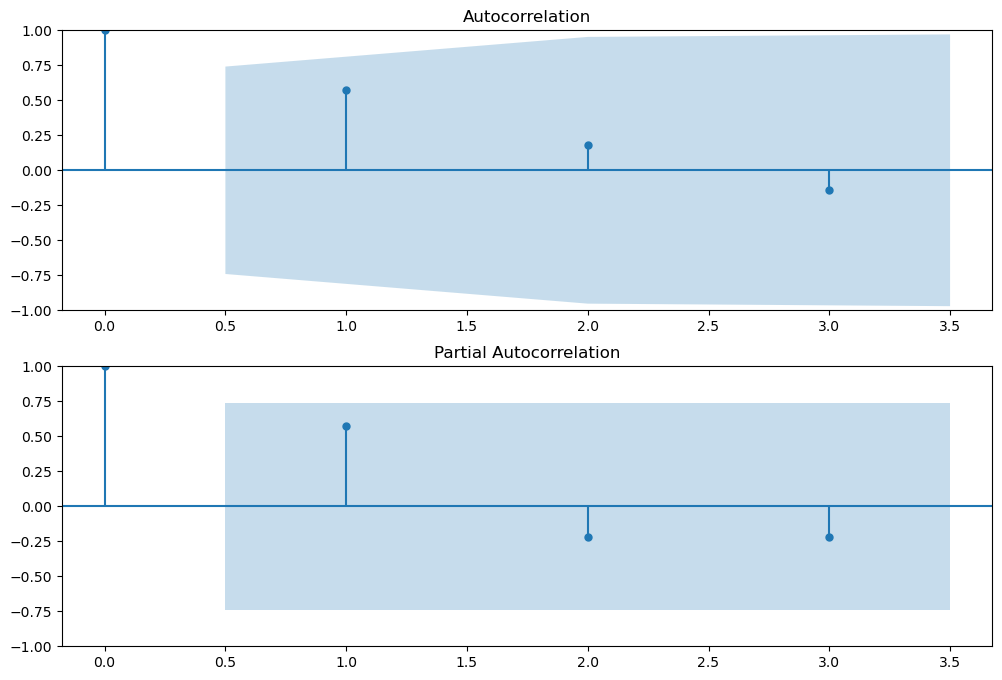

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF to check p,q
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

max_lags = min(len(train) // 2, 5)

plot_acf(train, ax=ax[0], lags=max_lags)
plot_pacf(train, ax=ax[1], lags=max_lags)

plt.show()

In [35]:
# use itertools to determine the range
import itertools

p = range(0,8)
q = range(0,8)
d = range(0,2)

pdq_combination = list(itertools.product(p,d,q))

len(pdq_combination)

128

In [36]:
# 
rmse=[]
order1=[]

In [37]:
#  iterate to get the pdq combination with the least rmse and append to a list.
from sklearn.metrics import mean_squared_error
for pdq in pdq_combination:
    try:
        model= ARIMA(train,order = pdq).fit()
        pred = model.predict(start=len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)

    except Exception as e:
        print(f"Error encountered for {pdq}: {e}")
        continue

Error encountered for (5, 0, 0): LU decomposition error.


In [38]:
# add list of results to convert to csv file
results = pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [39]:
# download results to a csv file
results.to_csv('ARIMA_result_generated.csv')

In [99]:
# train model using the pdq
model = ARIMA(train, order=(2,1,1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                    7
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10784.872
Date:                Fri, 26 Apr 2024   AIC                          21577.744
Time:                        19:45:06   BIC                          21576.911
Sample:                    01-01-2010   HQIC                         21574.410
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0108      0.001    -18.501      0.000      -0.012      -0.010
ar.L2          0.9835      0.001   1731.408      0.000       0.982       0.985
ma.L1          0.9189      0.008    116.620      0.0

In [100]:
# make test predictions to evaluate model performance
start = len(train)
end = len(df)-1
pred = model.predict(start=start, end=end,)
print(pred)

2017-01-01    1.542271e+06
2018-01-01    1.571001e+06
2019-01-01    1.600360e+06
2020-01-01    1.628297e+06
2021-01-01    1.656868e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [101]:
#model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

error = mean_squared_error(test,pred)

In [102]:
rmse = np.sqrt(error)
mae = mean_absolute_error(test, pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 2120.122260947988
Mean Absolute Error (MAE): 1924.8520185738803


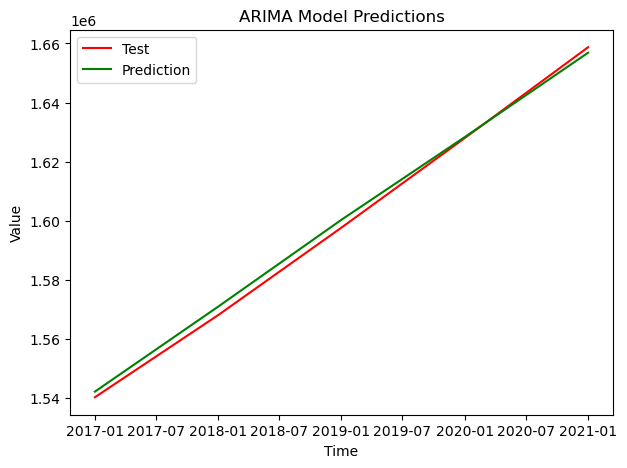

In [103]:
# Plot all data on the same graph
plt.figure(figsize=(7, 5))

# Plot testing data
plt.plot(test.index, test.values, label='Test', color='red')

# Plot predictions
plt.plot(pred.index, pred.values, label='Prediction', color='green')


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions')


plt.legend()

In [92]:
# make final prediction using the test pdq value
final_model = ARIMA(df,order=(2,1,1)).fit()
prediction = final_model.predict(len(df),len(df)+8)

In [93]:
print(prediction)

2022-01-01    1.685820e+06
2023-01-01    1.712140e+06
2024-01-01    1.737712e+06
2025-01-01    1.762557e+06
2026-01-01    1.786696e+06
2027-01-01    1.810149e+06
2028-01-01    1.832935e+06
2029-01-01    1.855073e+06
2030-01-01    1.876582e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

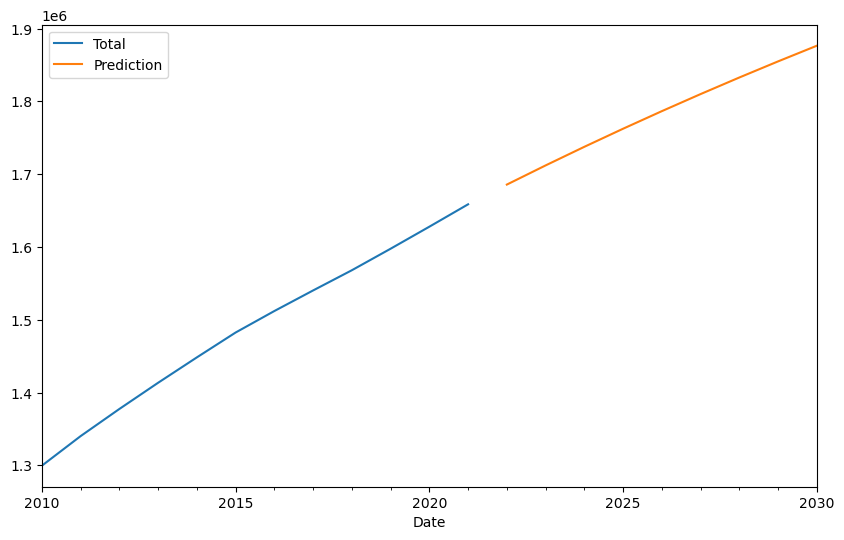

In [94]:
# plot prediction
df.plot(legend= True, label='Train', figsize=(10,6))
prediction.plot(legend= True, label='Prediction',)

In [95]:
# find the mean of the dataset
mean_actual_values = df.mean()

In [106]:
# determine the percentage accuracy using the rmse and mean
percentage_rmse_mean = (rmse / mean_actual_values) * 100
accuracy = 100 - percentage_rmse_mean
print(rmse)
print(accuracy)

2120.122260947988
Total    99.857605
dtype: float64


In [104]:
# model evaluation with r2 score
from sklearn.metrics import r2_score

r2 = r2_score(test,pred)

print(f'R-squared score: {r2}')


R-squared score: 0.9974447982357958


In [107]:
# append results to a csv file
file_path = 'arima_generated_predictions.csv'

prediction.to_frame().to_csv(file_path, header=['Predictions'])